# <center>115 Final Project - Verlet Velocity</center> 
## <center>1D & 2D Particle Simulations </center> 
### <center>Written and Programmed by Zev Balme</center> 

# Verlet Velocity Background:
When we analyze large systems that involve many particles, intermolecular forces are typically ignored and the system is treated to be like an ideal gas. When we do include these forces, it is nearly impossible to describe all the forces acting on non-symmetrical systems by hand, however, with simulations the computer can keep track of all these variables as a system evolves. Verlet Velocity is a system of equations that approximate the movement of particles in a many-body system. Using small time steps, and thousands of calculations, one can calculate how a system will evolve in multiple dimensions. This is done by calculating the total force on particles and their velocity throughout the system. Then with the help of simple kinematics, it updates the positions of the particles throughout time. 

The three equations we will be using in our calculations are:

<center>$$r_i(t+h) \approx r_i(t) + hv_i(t) + \frac{h^2}{2}F_i(t) $$ 
    
<center>$$v_i(t+h) \approx v_i(t) + h\left[\frac{F_i(t+h) + F_i(t)}{2}\right]$$
    
<center>$$F_i(r(t)) = \sum_{i\neq j}^{N} \frac{48}{r}\left[\frac{1}{r^{12}}-\frac{1}{2r^6}\right]$$

where r is the dist from $r_i$ to a $r_j$
    
The force equation used is derived from the Lennard-Jones effective potential. This is commonly used in molecular dynamics simulations however not the only force these equations work for.



## Aproximations of larger simulations

To handle large particle simulations, we make an approximation of a larger system. To do this we construct a box containing the particles. Once a particle has exited the box, we assume that the force it would contribute to the remaining particles is negligible. To keep the total particles the same throughout the simulation, we add a new particle on the opposite edge of the box so it appears as if the particle has wrapped around the box.

## Force

The force used in the calculations is attractive when the distance is greater than 1.25. Under this distance, the force becomes incredibly repulsive. If particles in the simulation can move further into this barrier than would naturally occur, energy will be added into the system and can cause breaks. Bellow, I have graphed this force distribution to better illustrate the point.

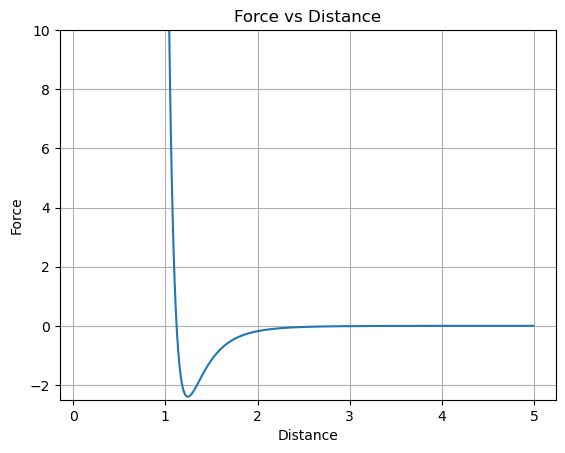

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def forcegraph(r):
    return 48/r * (1/r**12 - 1/(2*r**6))

dists = np.arange(.1,5,.01)
plt.plot(dists,forcegraph(dists))
plt.ylim(-2.5,10)
plt.grid()
plt.xlabel("Distance")
plt.ylabel("Force")
plt.title("Force vs Distance")
plt.show()

As seen in the plot above the force is attractive for distances greater than 1.1225, and blows up for smaller distances. If traveling through the edge of the box, and another particle is at that new edge, the force will become very great and break the simulation. Reducing time step size can help this issue but a better solution is to think of the box as having a clones on either side. To do this, we can take the smallest distance between particles in the box and in the clone boxes and calculate force over the edge of the box. 

This solution works rather well for initial spacings above .5 but below that, the initial energy in the box can still cause issues. If time steps are too large, the position updates can still put particles closer together than would be possible in a real system. This leads to additional energy being added to the system and compounding errors.

## Testing Accuracy
I will be testing the accuracy of the calculations in 2 methods. First, energy should be conserved throughout the system so I will make sure the initial and final energies are the same. This will be accomplished with the use of three equations.

<center> $$ E = T + V $$

<center> $$ T = \frac{1}{2} \sum_{i=0}^{N-1} v_i^2 $$

<center> $$ V = \sum_{i=0}^{N-1} \sum_{i+1}^{N-1} 4\left[\frac{1}{\Delta r_{ij}^{12}}-\frac{1}{\Delta r_{ij}^6}\right] $$
    
The other testing method I will use will be to run the simulation in reverse starting with the ending values to ensure that the system is repeatable.

# 1D Simulation

The code below models the 1D particle simulation. The key aspect of this section is to learn about adding mirror particles when calculating force to prevent explosions and the order of operations. Looking back at equations 1-3, we see that we need to first update the position, then the force, and finally the velocity. The movement in this simulation should resemble billiard balls as mentioned in Ref. 1.

In [58]:
%matplotlib inline
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
import matplotlib as mpl
import math

# CONTROLS
fast = 0

debugstart = 0  # [in ms]
debugend = 0  # [in ms]
x = np.arange(-4, 4, .8)  # init pos
vx = np.zeros(len(x))  # init velos
fx = np.zeros(len(x))  # init forces
box = [-15, 15]  # edge locations
mass = np.ones((len(x)))
h = .001  # time step
endtime = 5  # [seconds]

# CODE
time = 0


def distcalc(r1, r2):
    return np.sqrt(np.sum((r1 - r2) ** 2)) * np.sign(r1 - r2)


def forcef(r1, r2):
    r = np.sqrt(np.sum((r1 - r2) ** 2)) * np.sign(r1 - r2)
    r = 48 / r * (1 / (r ** 12) - 1 / (2 * r ** 6))
    if fast:
        r *= 10
    return r


def forcef2(r):
    forceval = 48 / r * (1 / (r ** 12) - 1 / (2 * r ** 6))
    if fast:
        forceval *= 10
    return forceval


def bestf(r1, r2, j, k, edge=[-10, 10]):
    # creates and evalutes the distance between particle 1 and particle 2 and the created mirror particles
    r2rb = r2 + edge[0] - edge[1]            # adds mirror particle to the left side of the box
    r2lb = r2 + edge[1] - edge[0]            # adds mirror particle to the right side of the box
    dists = [distcalc(r1, r2), distcalc(r1, r2lb), distcalc(r1, r2rb)]  # makes array of the distances 

    index = np.argmin(np.abs(dists))         # finds the ID of the smallest distance 

    if time > debugstart and time < debugend:
        print(
            f"time {time}, r{j} {r1}, r{k} {r2}, dist {dists[index]}, dir {'inside' if index == 0 else 'left ' if index == 1 else 'right'}")

    return forcef2(dists[index])             # calculates force using the minimum distance 


def u(r1, r2):
    r = np.sqrt(np.sum((r1 - r2) ** 2))
    return 4 * (1 / r ** 12 - 1 / (r ** 6))


def pos(r, h, v, f):
    # calculates updated positions
    return r + h * v + (h ** 2) / 2 * f          # Kinematic equation for position update 


def vel(v, h, F1, F2):
    # calculates updated velocity
    return v + h * (F2 + F1) / 2                  # update for velocity



def boundry(edge, x):
    # repositions particles that exit the box to the other side of the box that they exited.
    for i in range(len(x)):
        if x[i] > edge[1]:
            fact = int(x[i] / edge[1])
            # print(fact,x[i])
            x[i] += -fact * edge[1] - edge[1]
            # print(x[i])
        if x[i] < edge[0]:
            fact = int(x[i] / edge[0])
            x[i] += -fact * edge[0] - edge[0]

    return x

# creates arrays for data to fill in 
times = np.arange(0, endtime, h)
tot_f = np.zeros(len(x))
xlist = np.zeros((len(x), len(times)))
xlist[:, 0] = x
ylist = np.zeros(len(times))
flist = np.zeros((len(x), len(times)))
vel_list = []
###


for i in range(len(vx)):  # turn back on
    vx[i] = np.cos((random.uniform(0, 2 * np.pi)))    # makes random velocites for the inital states of the particles

vel_int = np.copy(vx)                                 # records inital velocites for energy calculations
vel_list.append(vel_int)

for i in range(len(x)):
    for j in range(len(x)):
        if i == j:
            continue
        tot_f[i] += bestf(xlist[i, 0], xlist[j, 0], i, j, box)     # calcualtes the inital force of the particles

flist[:, 0] = tot_f                                   # adds inital force to the 0 time step of the 

def calc_1d():
    for i in range(1, len(times)):                        # iterates over all time steps
        time = times[i]
        for j in range(len(x)):                           # iterates over all particles 
            xlist[j, i] = pos(xlist[j, i - 1], h, vx[j], flist[j, i - 1])   # updates the position of the particles
            xlist[:, i] = boundry(box, xlist[:, i])       # makes sure all particles are in the box

        for j in range(len(x)):                           # iterates over all particles
            for k in range(len(x)):                       # iterates over all particles 
                if k == j:                                # skips self interaction terms
                    continue
                flist[j, i] += bestf(xlist[j, i], xlist[k, i], j, k, box) #calculates force for the particles
            vx[j] = vel(vx[j], h, flist[j, i - 1], flist[j, i]) # updates velocites 
        vel_list.append(vx)

calc_1d()
        
# bookkeeping 
part_1d = np.copy(xlist)
mass_1d = np.copy(mass)
box_1d = np.copy(box)
vel_1d = np.copy(vx)
vel_int_1d = np.copy(vel_int)
f_1d = np.copy(flist)
y_1d = np.copy(ylist)
vel_list_1d = np.copy(vel_list)

## Animation and x vs. time plot

This section shows the results of the simulation. For the 1D case, the simulation is more enjoyable to watch than useful for analysis. It does interact as expecting, resembling billiard balls but deriving useful information from this simulation is difficult.

<IPython.core.display.Javascript object>


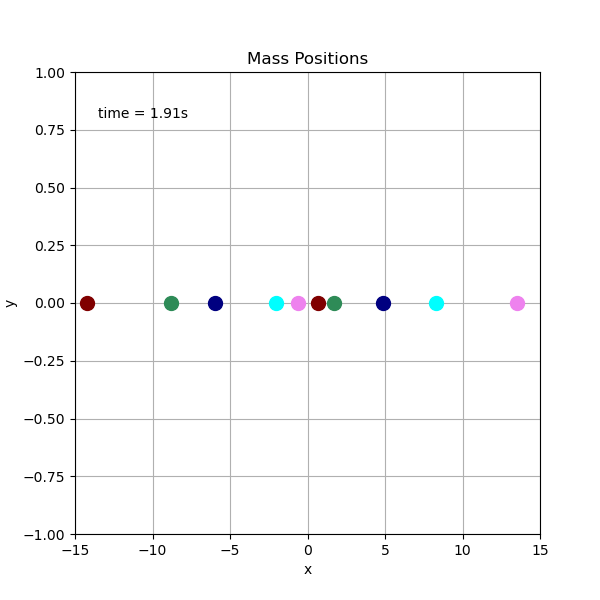

In [59]:
%matplotlib notebook
# %matplotlib inline


num_points = len(vel_1d)    # counts particles in the sim

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_1d[0],box_1d[1]), ylim=(-1, 1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']   # I picked colors I like for readablity in the animation
markers = [ax.plot([], [], 'o-', markersize=10, color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]  # creates markers for each particle

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    # Animates the data
    for j, marker in enumerate(markers):
        marker.set_data([part_1d[j, i]], [y_1d[i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times)), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()


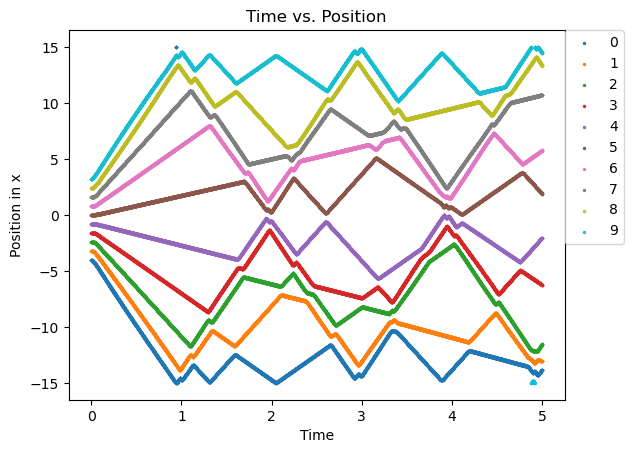

In [60]:
%matplotlib inline

for i in range(len(vel_1d)):
    plt.scatter(times, part_1d[i, :], label=(f'{i}'), s=2)
plt.xlabel("Time")
plt.ylabel("Position in x")
plt.title("Time vs. Position")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0) #moves the legend outside the graph
plt.show()

The plot of the 1D simulation is a much better analysis of the movement of the particles. As seen above the particles approach each other but never touch as they are treated with no radius. Since the particles are all of mass 1, the collisions are elastic and this is reflected in the graph above. Additionally, we can see the particles traveling over the walls and looping to the other side. 

## Energy Conservation Test

In [61]:
def energycalc(U,T):
    # adds the potentail and kenetic energy
    return U + T

def pot(r):
    # calcualtes the potential energy for a given distance
    pot = 4 * (1 / (r ** 12) - 1 / (r ** 6))
    if fast:
        pot *= 10
    return pot

def best_potential(r1,r2,edge):
    # since the force is calculated with mirror particles, potential must be calculated the same way
    r2rb = r2 + edge[0] - edge[1]
    r2lb = r2 + edge[1] - edge[0]
    dists = [distcalc(r1, r2), distcalc(r1, r2lb), distcalc(r1, r2rb)]

    lowest = 1e100
    index = 0
    for i in range(len(dists)):
        if abs(dists[i]) < lowest:
            lowest = abs(dists[i])
            index = i

    return pot(dists[index])

U = [0,0]
T = [1/2*np.sum(vel_int_1d**2),1/2*np.sum(vel_1d**2)]    # calculates the kenetic energy
for i in range(len(vel_1d)):                             # iterates over all particles 
    for j in range(i+1,len(vel_1d)):                     # iterates over all particles not yet counted, prevents double counting 
        if i == j:                                       # skips self interation 
            continue 
        U[0] += best_potential(part_1d[i,0],part_1d[j,0],box_1d)
        U[1] += best_potential(part_1d[i,-1],part_1d[j,-1],box_1d)

print(f"Intial Energy = {round(energycalc(U[0],T[0]),4)} \nFinal Energy  = {round(energycalc(U[1],T[1]),4)}")
print(f"Energy Change =", round(energycalc(U[0],T[0]) - energycalc(U[1],T[1]),6) )

Intial Energy = 386.7783 
Final Energy  = 386.7733
Energy Change = 0.004981


As seen above the total energy in the system is conserved to the $10^{-2}$, while less than initially planned, this is still a good showing that the total energy in the system remains the same throughout a simulation. If ran with a step size of $10^{-4}$ we do end up with an error of $10^{-5}$. This shows that the code functions but the accuracy is very dependent on your step size as predicted. This is because the simulation doesn't move with infinite steps between seconds as the real world does. Instead, the simulation guesses as to where the particles would be in a time step and teleports them into that position. With a force that scales so inconsistently, these guesses have a chance to create far more energy than would be possible in a real system and these errors are made more likely with bigger step sizes.

## Reverse System Test
For this test, I have taken the final position, velocity, and force of the system. I then inverted the velocity and let the calculation occur in reverse time.

In [62]:
vx_rev = np.copy(vel_1d)        # takes final vel data from regular calculation 
vx_rev = -vx_rev                # flips the final velocity of the forward system

# sets initial states 
times_rev = np.arange(0, endtime, h)
tot_f_rev = np.zeros(len(vel_1d))
xlist_rev = np.zeros((len(vel_1d), len(times)))
x_rev = np.copy(part_1d[:,-1])
xlist_rev[:, -1] = x_rev
ylist = np.zeros(len(times))
flist_rev = np.zeros((len(vel_1d), len(times)))

vel_int = np.copy(vx_rev)
f_rev = np.copy(f_1d[:,-1])
flist_rev[:, -1] = f_rev

# does calculations from forward but with time decresing
for i in range(2, len(times)+1):
    time = times[-i]
    for j in range(len(vel_1d)):
        xlist_rev[j, -i] = pos(xlist_rev[j, -i + 1], h, vx_rev[j], flist_rev[j, -i + 1])
        xlist_rev[:, -i] = boundry(box, xlist_rev[:, -i])

    for j in range(len(vel_1d)):
        for k in range(len(vel_1d)):
            if k == j:
                continue
            flist_rev[j, -i] += bestf(xlist_rev[j, -i], xlist_rev[k, -i], j, k, box)
        vx_rev[j] = vel(vx_rev[j], h, flist_rev[j, -i + 1], flist_rev[j, -i])



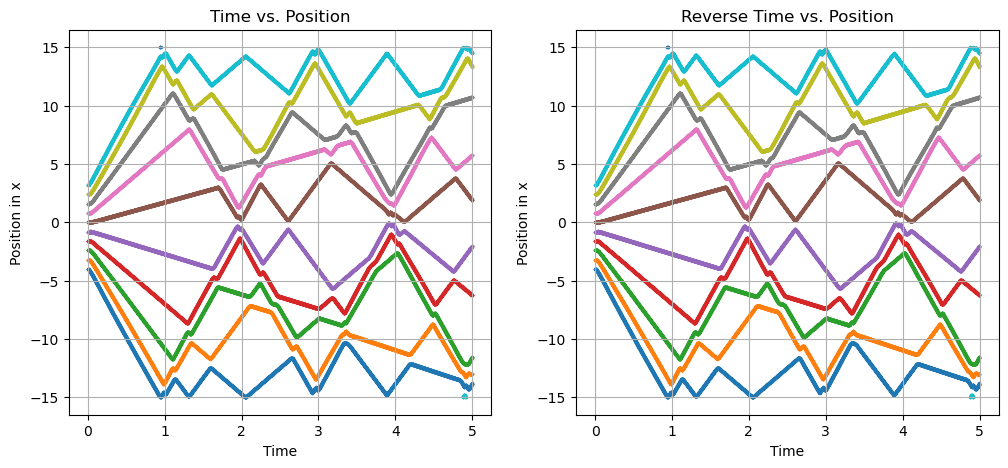

In [63]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 5))

for i in range(len(vel_1d)):
    ax1.scatter(times, part_1d[i, :], label=(f'{i}'), s=2)
ax1.set_xlabel('Time')
ax1.set_ylabel('Position in x')
ax1.set_title('Time vs. Position')
ax1.grid()

for i in range(len(vel_1d)):
    ax2.scatter(times_rev, xlist_rev[i, :], label=(f'{i}'), s=2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Position in x')
ax2.set_title('Reverse Time vs. Position')
ax2.grid()


plt.show()


As required running the calculations from the end results in the same plot.

## Pressure and Temperature
To show one of the applications of this type of simulation, we can show how temperature and pressure in a system evolve over time for non-ideal gasses. The first thing we should expect is an initial high pressure and low temperature. At the end of the system, the pressure should decrease and the temperature should rise. Where this is even more interesting is how the pressure of the system can continue to evolve even after temperature has reached a steady state due to particle interactions. To calculate the Pressure and Temperature, I will be using the following equations:

<center> $$ T = \frac{2 KE}{3 k_b N} $$
<center> $$ P = \frac{2 KE + w}{3 N V}$$ 
<center>$$ w = \sum_{i<j}^{N} r_{ij}*f_{ij}$$
    
In the first equation calculates temperature with KE being the kinetic energy in the system, $k_b$ is the Boltzmann constant (set to 1 for simplicity), and N is the number of particles. The second equation calculates the pressure with the same terms as the first equation and with V equal to the volume. The third equation is the weighted average of the forces and disappears for non-interacting calculations.  

In [64]:
def temp(KE,N):
#     kb = 1.38 * 10**(-23)
    kb =1 
    return 2/3*KE/(kb*N)

def weight(r1,r2,edge):
    r2rb = r2 + edge[0] - edge[1]
    r2lb = r2 + edge[1] - edge[0]
    dists = [distcalc(r1, r2), distcalc(r1, r2lb), distcalc(r1, r2rb)]

    lowest = 1e100
    index = 0
    for i in range(len(dists)):
        if abs(dists[i]) < lowest:
            lowest = abs(dists[i])
            index = i

    r = dists[index]
    f = forcef2(dists[index]) 
    w = r*f
    return w

def P(N,V,KE,w):
    return (2/3 * 1/V) * (KE + w)

w_int = 0
w_final = 0
for i in range(len(vel_1d)):
    for j in range(1,len(vel_1d)):
        if i == j:
            continue
        w_int += weight(part_1d[i,0],part_1d[j,0],box_1d)
        w_final += weight(part_1d[i,-1],part_1d[j,-1],box_1d)

V = box_1d[1]-box_1d[0]
Temp = [temp(T[0],len(vel_1d)), temp(T[1],len(vel_1d))]
Presure = [P(len(vel_1d),V,T[0],w_int),P(len(vel_1d),V,T[1],w_final)]

print(f"Initial Temperature = {Temp[0]}, Initial Pressure = {Presure[0]}")
print(f"Final Temperature =   {Temp[1]}, Final Pressure =   {Presure[1]}")

Initial Temperature = 0.14713009656257398, Initial Pressure = 228.87424599122429
Final Temperature =   23.07523793469185, Final Pressure =   20.81396130675419


<function matplotlib.pyplot.show(close=None, block=None)>

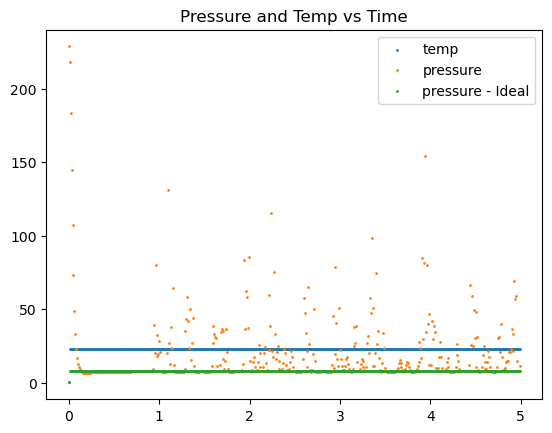

In [65]:
V = box_1d[1]-box_1d[0]
temp_1d = []
pres_1d = []
pres_1d_nobel = []
times_checked = []
for i in range(0,len(times),10):
    w = 0
    KE = 1/2*np.sum(vel_list_1d[i,:]**2)    # calculates the kenetic energy
    for j in range(len(vel_1d)):
        for k in range(1,len(vel_1d)):
            if j == k:
                continue
            w += weight(part_1d[j,i],part_1d[k,i],box_1d)
    temp_1d.append(temp(KE,len(vel_1d)))
    pres_1d.append(P(len(vel_1d),V,KE,w))
    pres_1d_nobel.append(P(len(vel_1d),V,KE,0))
    times_checked.append(i/1000)

plt.scatter(times_checked,temp_1d, s=1, label= "temp")
plt.scatter(times_checked,pres_1d, s=1, label = "pressure")
plt.scatter(times_checked,pres_1d_nobel, s=1, label = "pressure - Ideal")
plt.legend()
plt.title("Pressure and Temp vs Time")
plt.show




The plot above shows how the pressure and temperature of the system evolve over time. We see a steep fall off of pressure almost immediately and an immediate jump to higher temperatures. This makes sense as the high-pressure system is relaxed allowing the particles to begin moving leading to this increase in temperature. We can then see the temperature stay constant throughout time as the system's kinetic energy is balanced through elastic collisions and no more energy is entering the system. The pressure rises and falls throughout time as particles near collisions. This seems odd when we think of the equation $P = \frac{Nk_b T}{V}$ but that is only the equation for ideal gasses. When we have particle interactions we must add a term to the pressure relating the distance and force between the particles. To better illustrate this point, I have also plotted the Ideal gas law pressure throughout time that levels off at the same time the temperature does.

## Multiple Masses
To run the simulation with different values of mass, I thought about how these equations of motion would change. I came to the conclusion that the force was acting as acceleration and therefore divided the acceleration(force) term in the position and velocity calculations by the given masses. I also wanted the masses to be selected at random from a list of acceptable values so I built in a function to make a random selection.

In [84]:
# CONTROLS
fast = 0
multi_mass = 1

debugstart = 0  # [in ms]
debugend = 0  # [in ms]
x = np.arange(-4, 4, .7)  # init pos
vx = np.zeros(len(x))  # init velos
fx = np.zeros(len(x))  # init forces
mass = np.ones((len(x)))
box = [-15, 15]  # edge locations
h = 1e-3  # time step
endtime = 5  # [seconds]
acceptable_masses = [1,2,3]

# CODE
time = 0

def mass_selction(acceptable_mass):
    fitting = np.linspace(0,1,len(acceptable_mass)+1)         # makes an equal spacing to designate masses to
    for i in range(len(x)):
        a = random.random()                                   # gens a random number for each particle 
        for j in range(len(fitting)-1):                       # sorts each particle to a mass
            if j == 0:
                if a < fitting[j+1]:
                    mass[i] = acceptable_mass[j]
                    break
            else:
                if a > fitting[j] and a<fitting[j+1]:
                    mass[i] = acceptable_mass[j]
                    break


def distcalc(r1, r2):
    # calcs distacnce vector between two points 
    return np.sqrt(np.sum((r1 - r2) ** 2)) * np.sign(r1 - r2)

                    

def pos_m(r, h, v, f,mass = 1):
    # calcs new position with mass factored into the force
    return r + h * v + (h ** 2) / 2 * f/mass


def vel_m(v, h, F1, F2, mass = 1):
    # calcs new velocity with mass factored into the forces 
    return v + h * (F2/mass + F1/mass) / 2



# builds initial states
if multi_mass ==True:
    mass_selction(acceptable_masses)
times = np.arange(0, endtime, h)
tot_f = np.zeros(len(x))
xlist = np.zeros((len(x), len(times)))
xlist[:, 0] = x
ylist = np.zeros(len(times))
flist = np.zeros((len(x), len(times)))

for i in range(len(vx)):  # turn back on
    vx[i] = np.cos((random.uniform(0, 2 * np.pi)))

vel_int = np.copy(vx)

for i in range(len(x)):
    for j in range(len(x)):
        if i == j:
            continue
        tot_f[i] += bestf(xlist[i, 0], xlist[j, 0], i, j, box)


flist[:, 0] = tot_f


for i in range(1, len(times)):     # does calcs for each time step
    time = times[i]
    for j in range(len(x)):        # goes over each particle 
        xlist[j, i] = pos_m(xlist[j, i - 1], h, vx[j], flist[j, i - 1],mass[j])  #updates the positions of the particles 
        xlist[:, i] = boundry(box, xlist[:, i])   # makes sure particles are in the box


    for j in range(len(x)):        # iterates over all particles 
        for k in range(len(x)):    # iterates over all particles 
            if k == j:             # skips self interation 
                continue
            flist[j, i] += bestf(xlist[j, i], xlist[k, i], j, k, box) # calcs force on each particle 
        vx[j] = vel_m(vx[j], h, flist[j, i - 1], flist[j, i],mass[j]) # updates the velocites of the particles 

# bookkeeping 
part_1d_mm = np.copy(xlist)
mass_1d_mm = np.copy(mass)
box_1d_mm = np.copy(box)
vel_1d_mm = np.copy(vx)
vel_int_1d_mm = np.copy(vel_int)
f_1d_mm = np.copy(flist)
y_1d_mm = np.copy(ylist)

<IPython.core.display.Javascript object>


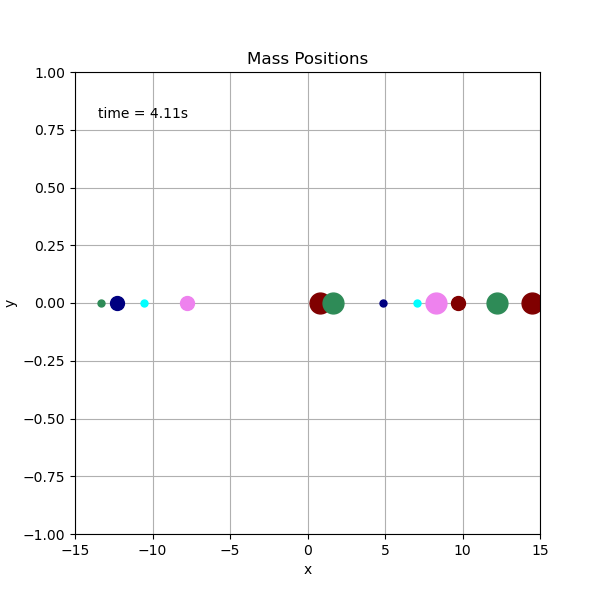

In [85]:
%matplotlib notebook
num_points = len(vel_1d_mm)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_1d_mm[0],box_1d_mm[1]), ylim=(-1, 1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']
markers = [ax.plot([], [], 'o-', markersize=[int(mass_1d_mm[_])*5][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]
# markers = [ax.plot([], [], 'o-', markersize=10)[0] for _ in range(num_points)]

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    for j, marker in enumerate(markers):
        marker.set_data([part_1d_mm [j, i]], [y_1d_mm[i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times),10), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()



## Energy Test for Multi-Mass System

In [86]:
U = [0,0]
T = [0,0]

for i in range(len(vel_1d_mm)):    # calcs potential and kenetic energy at the start and end of the sims
    for j in range(i+1,len(vel_1d_mm)):
        if i == j:
            continue 
        U[0] += best_potential(part_1d_mm[i,0],part_1d_mm[j,0],box_1d_mm)
        U[1] += best_potential(part_1d_mm[i,-1],part_1d_mm[j,-1],box_1d_mm)
    T[0] += 1/2*mass_1d_mm[i]*vel_int_1d_mm[i]**2
    T[1] += 1/2*mass_1d_mm[i]*vel_1d_mm[i]**2

print(f"Intial Energy = {round(energycalc(U[0],T[0]),4)} Joules \nFinal Energy  = {round(energycalc(U[1],T[1]),4)} Joules")
print(f"Energy Change =", round(energycalc(U[1],T[1]) - energycalc(U[0],T[0]),4),"Joules" )

Intial Energy = 2806.6204 Joules 
Final Energy  = 2811.2834 Joules
Energy Change = 4.663 Joules


Energy conservation seems to be worse in this system, this could be due to a misunderstanding of how the force is being used in the calculations but I am not entirely sure. However, the total conservation is still acceptable even if it is not perfect. My main concern with this version is that energy seems to be lost in the simulation. I would assume that there would be a net energy gain in the system due to the issues listed in the unitary mass simulation but the energy decreases throughout some simulations. I tried multiple fixes for this such as seeing if the potential should depend on the masses, average mass, etc. I also investigated the velocity term not depending on the mass of the particles but these all seemed to lead to significantly worse results. 

As a sanity test, I reduced step size by a factor of 10 and reran the simulation, energy is still lost but on the scale of $5*10^{-3}$. This shows that calculations are still being performed correctly even if there is a small energy leak in the system.

## Pressure and Temperature


In [69]:
w_mm_int = 0
w_mm_final = 0
for i in range(len(vel_1d_mm)):
    for j in range(1,len(vel_1d_mm)):
        if i == j:
            continue
        w_mm_int += weight(part_1d_mm[i,0],part_1d_mm[j,0],box_1d_mm)
        w_mm_final += weight(part_1d_mm[i,-1],part_1d_mm[j,-1],box_1d_mm)

V = box_1d_mm[1]-box_1d_mm[0]
Temp = [temp(T[0],len(vel_1d_mm)), temp(T[1],len(vel_1d_mm))]
Presure = [P(len(vel_1d_mm),V,T[0],w_mm_int),P(len(vel_1d_mm),V,T[1],w_mm_final)]

print(f"Initial Temperature = {Temp[0]}, Initial Pressure = {Presure[0]}")
print(f"Final Temperature =   {Temp[1]}, Final Pressure =   {Presure[1]}")

Initial Temperature = 0.3597768664336379, Initial Pressure = 1522.1785960616985
Final Temperature =   156.07857153077765, Final Pressure =   64.09737069913773


As shown above, the system starts with a large amount of pressure and very little temperature but as we let the particles interact the pressure falls and temperature rises. This is the same result as with a system of equal mass particles as expected.

# 2D Simulation

When converting the simulation to 2D, the math mostly stays the same but the way data is stored becomes more complex. The array to keep track of each particle condition for the 1D case required an array of the form [particle id][x-value][time]. When moving into 2d, this changes to the form [particle id][x-value, y-value][time]. The same change is required for the force and velocity arrays. The next major change that occurs is the force calculation for the particles. 

We still must account for particles traveling through walls so we must put clone particles surrounding the box including the corners. This takes the form of adding edges to each r2 value in our calculation for both x and y. Taking the magnitude distance between the particles and all mirror particles you find the minimum distance from the list and compute the force. After magnitude force is computed, you find the angle between the particles and apply the forces using magnitude force multiplied by cos($\theta$) for x and sin($\theta$) for y. The resulting calculations lead to the following code.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation

# controls
fast = 0
multi_mass = 0

debugstart = 0  # [in ms]
debugend = 0  # [in ms]

x = np.arange(-1,1,.7)  # init x positions 
y = np.arange(-1,1,.7)  # inital y positions 
particles = np.zeros([len(x)*len(y),2]) # builds empty set for the particles and there x,y positions 
count = 0
for i in range(len(x)):
    for j in range(len(y)):
        particles[count] = x[i],y[j]    # fills out the inital data set
        count +=1

# builds out arrays for data entry 
vy = np.zeros(len(particles))
vx = np.zeros(len(particles))  # init velos
f = np.zeros([len(x)*len(y),2])  # init forces
mass = np.ones((len(particles)))
box = [-15, 15,-15,15]  # edge locations
h = 1e-3  # time step
endtime = 5  # [seconds]
acceptable_masses = [1,2,4]

# CODE
time = 0


def mass_selction(acceptable_mass):
    # mass selector from earlier
    fitting = np.linspace(0,1,len(acceptable_mass)+1)
    for i in range(len(particles)):
        a = random.random()
        for j in range(len(fitting)-1):
            if j == 0:
                if a < fitting[j+1]:
                    mass[i] = acceptable_mass[j]
                    break
            else:
                if a > fitting[j] and a<fitting[j+1]:
                    mass[i] = acceptable_mass[j]
                    break

def distcalc_2d(r1, r2):
    # magnitude dist calc
    return np.sqrt(np.sum((r1 - r2) ** 2))


def forcef(r1, r2):
    # calcs force between 2 points
    r = np.sqrt(np.sum((r1 - r2) ** 2)) * np.sign(r1 - r2)
    r = 48 / r * (1 / (r ** 12) - 1 / (2 * r ** 6))
    if fast:
        r *= 10
    return r


def forcef2(r):
    # calcs force given a single distance
    forceval = 48 / r * (1 / (r ** 12) - 1 / (2 * r ** 6))
    if fast:
        forceval *= 10
    return forceval


def bestf_2d(r1, r2, j=0, k=0, edge=[-10, 10,-15,15]):
    # builds all mirror particle 
    r2s=[r2]
    r2s = np.append(r2s,[r2[0] + edge[0]-edge[1],r2[1]])
    r2s = np.append(r2s,[r2[0] + edge[1]-edge[0],r2[1]])
    r2s = np.append(r2s,[r2[0],r2[1]+ edge[2]-edge[3]])
    r2s = np.append(r2s,[r2[0],r2[1]+ edge[3]-edge[2]])
    r2s = np.append(r2s, [r2[0] + edge[0] - edge[1], r2[1] + edge[2] - edge[3]])
    r2s = np.append(r2s, [r2[0] + edge[0] - edge[1], r2[1] + edge[3] - edge[2]])
    r2s = np.append(r2s, [r2[0] + edge[1] - edge[0], r2[1] + edge[2] - edge[3]])
    r2s = np.append(r2s, [r2[0] + edge[1] - edge[0], r2[1] + edge[3] - edge[2]])

    
    r2s = np.reshape(r2s, (9,2))           # reshapes the mirror set into x and y values

    dists = np.zeros((len(r2s)))
    for i in range(len(r2s)):
        dists[i] = distcalc_2d(r1,r2s[i])     # calcs all dists between r1 and r2+mirrors

    index = np.argmin(np.abs(dists))       # finds index of smallest distance 

    if time > debugstart and time < debugend:
        print(
            f"time {time}, r{j} {r1}, r{k} {r2}, dist {dists[index]}, dir {'inside' if index == 0 else 'left ' if index == 1 else 'right'}")


    deltay = r1[1]-r2s[index,1]
    deltax = r1[0]-r2s[index,0]
    
    # calcs the angle between the particles 
    if deltax == 0:
        if np.sign(deltay) == 1:
            theta = 0
        else:
            theta = np.pi
    else:
        theta = (np.arctan((deltay)/(deltax))) % (np.pi/2)   # takes theta mod pi/2 to account for tan^-1 limitations
        if np.sign(deltay) == -1:
            if np.sign(deltax) == -1:
                theta += np.pi
            else:
                theta += 3*np.pi/2
        else:
            if np.sign(deltax) == -1:
                theta += np.pi/2
        if deltay == 0:
            if np.sign(deltax) == -1:
                theta = np.pi
    f = forcef2(dists[index])
    fx = f * round(np.cos(theta),10)   #fix rounding errors for pi values
    fy = f * round(np.sin(theta),10)   #numpy can't compute sin(pi)
    return fx,fy


def u(r1, r2):
    # calcs potential energy 
    r = np.sqrt(np.sum((r1 - r2) ** 2))
    return 4 * (1 / r ** 12 - 1 / (r ** 6))


def pos(r, h, v, f,mass = 1):
    # updates the position
    return r + h * v + (h ** 2) / 2 * f/mass


def vel(v, h, F1, F2, mass = 1):
    # updates the velocities 
    return v + h * (F2/mass + F1/mass) / 2


def boundry_2d(edge, x):
    # moves particles inside box
    if x > edge[1]:
        fact = int(x / edge[1])
        # print(fact,x)
        x += -fact * edge[1] - edge[1]
        # print(x)
    if x < edge[0]:
        fact = int(x / edge[0])
        x += -fact * edge[0] - edge[0]
    if x > edge[3]:
        fact = int(x / edge[3])
        # print(fact,x)
        x += -fact * edge[3] - edge[3]
        # print(x)
    if x < edge[2]:
        fact = int(x / edge[2])
        x += -fact * edge[2] - edge[2]

    return x

# sets initial conditions 
if multi_mass ==True:
    mass_selction(acceptable_masses)
times = np.arange(0, endtime, h)
pos_list = np.zeros((len(x)*len(y),2,len(times)))
pos_list[:,:,0] = particles
tot_f = np.zeros((len(x)*len(y),2))
flist = np.zeros((len(x)*len(y),2, len(times)))
vel_list = []
for i in range(len(particles)):  # turn back on
    rand_num = (random.uniform(0, 2 * np.pi))
    vx[i] = np.cos(rand_num)
    vy[i] = np.sin(rand_num)
    vel_list.append([vx[i],vy[i]])
vel_int = np.copy(vel_list)
vel_list=np.array(vel_list)
vel_int = np.copy(vel_list)


for i in range(len(particles)):
    for j in range(len(particles)):
        if i == j:
            continue
        a,b = bestf_2d(particles[i], particles[j], i, j, box)
        # print(a,b)
        tot_f[i] += a,b


particles
flist[:,:,0] = tot_f

for i in range(1, len(times)):     # iterates over the time slices
    time = times[i]
    for j in range(2):             # iterates for both x and y variables 
        for k in range(len(pos_list[:,j,i])):   # iterates over all particles 
            pos_list[k,j,i] = pos(pos_list[k,j,i-1], h, vel_list[k,j], flist[k,j,i-1],mass[k]) # updates positions 
            pos_list[k,j,i] = boundry_2d(box, pos_list[k,j,i])                    # put the particles back in the box

    for j in range(len(particles)):     # iterates over all particles
        for k in range(len(particles)): # iterates over all particles
            if k == j:                  # skips self interations 
                continue
            a, b = bestf_2d(pos_list[j,:,i], pos_list[k,:,i], i, j, box) # calcs force on the particles
            flist[j,:,i] += a, b
    for j in range(2):                  # iterates over x and y variables 
        for k in range(len(pos_list[:,j,i])):  # iterates over all particles
            vel_list[k,j] = vel(vel_list[k,j], h, flist[k,j, i - 1], flist[k,j, i],mass[k])  # updates velocities 


# bookkeeping 
part_2d = np.copy(pos_list)
vel_int2d = np.copy(vel_int)
vel_final_2d = np.copy(vel_list)
flist_2d = np.copy(flist)
mass_2d = np.copy(mass)
box_2d = np.copy(box)

## Animation

For the 2D case, the animation is much more helpful than the graph of the particles as you can see the interactions throughout time without much visual clutter. The animation for a set of particles with random initial velocities has been displayed below.

<IPython.core.display.Javascript object>


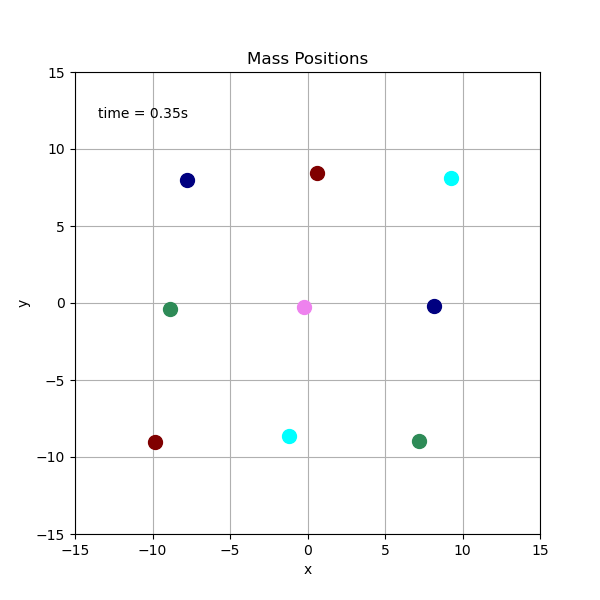

In [71]:
%matplotlib notebook

num_points = len(vel_final_2d)
multi_mass = 0

# print((num_points))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_2d[0],box_2d[1]), ylim=(box_2d[2], box_2d[3]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']
if multi_mass == True:
    markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d[_])*3][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]
else:
    markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d[_])*10][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]

    # markers = [ax.plot([], [], 'o-', markersize=10)[0] for _ in range(num_points)]

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    for j, marker in enumerate(markers):
        marker.set_data([part_2d[j,0, i]], [part_2d[j,1,i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times)), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()


## Graphs


<IPython.core.display.Javascript object>


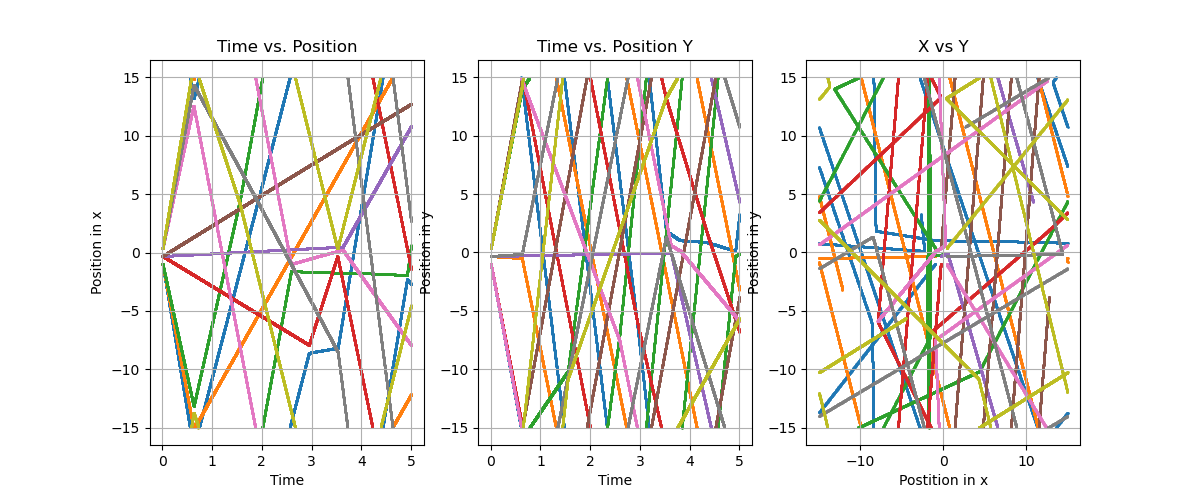

In [72]:
fig, [ax1, ax2,ax3] = plt.subplots(1,3, figsize=(12, 5))

for i in range(len(vel_final_2d)):
    ax1.scatter(times, part_2d[i,0,:], label=(f'{i}'), s=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Position in x')
ax1.set_title('Time vs. Position')
ax1.grid()

for i in range(len(vel_final_2d)):
    ax2.scatter(times, part_2d[i,1,:], label=(f'{i}'), s=1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Position in y')
ax2.set_title('Time vs. Position Y')
ax2.grid()

for i in range(len(vel_final_2d)):
    ax3.scatter(part_2d[i,0,:], part_2d[i,1,:], label=(f'{i}'), s=1)
ax3.set_xlabel('Postition in x')
ax3.set_ylabel('Position in y')
ax3.set_title('X vs Y')
ax3.grid()



The three plots above describe the positions of the particles throughout time. Unfortunately, this leads to a large amount of visual clutter making these plots less useful than the animation. The first plot shows the x position of each particle throughout time, the second plot shows the y position of each particle throughout time and the third plot shows the x and y positions of the particles for all time.  

## Energy Conservation

In [73]:
def bestpot2d(r1, r2, j=0, k=0, edge=[-10, 10,-15,15]):
    # evaluates the mirror dimension particles
    r2s=[r2]
    r2s = np.append(r2s,[r2[0] + edge[0]-edge[1],r2[1]])
    r2s = np.append(r2s,[r2[0] + edge[1]-edge[0],r2[1]])
    r2s = np.append(r2s,[r2[0],r2[1]+ edge[2]-edge[3]])
    r2s = np.append(r2s,[r2[0],r2[1]+ edge[3]-edge[2]])
    r2s = np.append(r2s, [r2[0] + edge[0] - edge[1], r2[1] + edge[2] - edge[3]])
    r2s = np.append(r2s, [r2[0] + edge[0] - edge[1], r2[1] + edge[3] - edge[2]])
    r2s = np.append(r2s, [r2[0] + edge[1] - edge[0], r2[1] + edge[2] - edge[3]])
    r2s = np.append(r2s, [r2[0] + edge[1] - edge[0], r2[1] + edge[3] - edge[2]])


    r2s = np.reshape(r2s, (9,2))

    dists = np.zeros((len(r2s)))
    for i in range(len(r2s)):
        dists[i] = distcalc_2d(r1,r2s[i])


    lowest = 1e100
    index = 0
    for i in range(9):
        if abs(dists[i]) < lowest:
            lowest = abs(dists[i])
            index = i

    potential = pot(dists[index])

    return potential

U = [0,0]
T = [0,0]

for i in range(len(vel_int2d)):
    for j in range(i+1,len(vel_int2d)):
        if i == j:
            continue 
        U[0] += bestpot2d(part_2d[i,:,0],part_2d[j,:,0],box_2d)
        U[1] += bestpot2d(part_2d[i,:,-1],part_2d[j,:,-1],box_2d)
    T[0] += 1/2*mass_2d[i]*np.sqrt(vel_int2d[i,0]**2+vel_int2d[i,1]**2)**2
    T[1] += 1/2*mass_2d[i]*np.sqrt(vel_final_2d[i,0]**2+vel_final_2d[i,1]**2)**2


# print(U)
# print(T)

print(f"Intial Energy = {round(energycalc(U[0],T[0]),4)} \nFinal Energy  = {round(energycalc(U[1],T[1]),4)}")
print(f"Energy Change =", round(energycalc(U[1],T[1]) - energycalc(U[0],T[0]),4) )

Intial Energy = 3061.5939 
Final Energy  = 3081.7694
Energy Change = 20.1755


Similar to the 1D case, the simulation conserves energy but the precision is greatly dependent on the time step size. For a perfect simulation time steps should go to 0. For user-friendliness, a time step of $10^{-3}$ is recommended although this will create an energy difference of up to 50J. Taking the time steps down to $10^{-4}$ will only add .09J into the system over the simulation. While not perfect, computation speed is the primary limiting factor in the accuracy of the model. I believe this also displays a new form of error introduced by the angle calculation in the force. I have noticed a rounding error within the calculations that I have attempted to fix by rounding the angles to the 10th decimal point. 

The specific error I am referring to is np.sin(np.pi) = 1.2246467991473532e-16. While this is close to 0, these rounding errors compound as time increases throughout the system and will lead to these larger errors.

## Reverse time trial

Following the same process as in 1D, we take the final velocity, force, and position of the particles and check to make sure that the particles return to the same initial state.

In [74]:
vel_list = -vel_final_2d                          # reverses final vel
pos_list[:,:,0] = part_2d[:,:,-1]                 # takes final positions
flist = np.zeros((len(vel_list),2, len(times)))   # makes set for forces
flist[:,:,0] = flist_2d[:,:,-1]                   # takes final force

# runs calculations from previous section 
def compute2():
        for i in range(1, len(times)):            # 
            time = times[i]
            for j in range(2):
                for k in range(len(pos_list[:,j,i])):
                    pos_list[k,j,i] = pos(pos_list[k,j,i-1], h, vel_list[k,j], flist[k,j,i-1],mass[k])
                    pos_list[k,j,i] = boundry_2d(box, pos_list[k,j,i])

            for j in range(len(particles)):
                for k in range(len(particles)):
                    if k == j:
                        continue
                    a, b = bestf_2d(pos_list[j,:,i], pos_list[k,:,i], i, j, box)
                    flist[j,:,i] += a, b
            for j in range(2):
                for k in range(len(pos_list[:,j,i])):
                    vel_list[k,j] = vel(vel_list[k,j], h, flist[k,j, i - 1], flist[k,j, i],mass[k])
compute2()

part_2d_rev = np.copy(pos_list)
vel_int2d_rev = np.copy(vel_int)
vel_final_2d_rev = np.copy(vel_list)
flist_2d_rev = np.copy(flist)

<IPython.core.display.Javascript object>


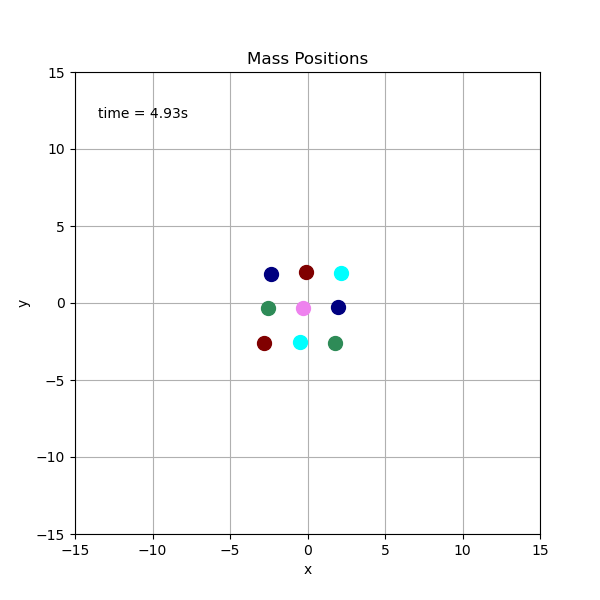

In [75]:
%matplotlib notebook

num_points = len(vel_final_2d_rev)
multi_mass = 0

# print((num_points))
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_2d[0],box_2d[1]), ylim=(box_2d[2], box_2d[3]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']
if multi_mass == True:
    markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d[_])*3][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]
else:
    markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d[_])*10][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]

    # markers = [ax.plot([], [], 'o-', markersize=10)[0] for _ in range(num_points)]

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    for j, marker in enumerate(markers):
        marker.set_data([part_2d_rev[j,0, i]], [part_2d_rev[j,1,i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times)), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()


Due to the issue of readability regarding the plot of the 2D system, I used the animation and showed the particles starting the negative ending velocity. As seen above, the particles fall back to their original state at the end of the simulation showing that this simulation also works for the reverse system test. 

## Multi-Mass System

In this simulation, I ran the system with randomized masses as was done for 1D. I also considered what would happen with a reduced box size leading to more collisions. I find this to be the most interesting simulation in the project as we see particles pushing and pulling both inside the box and with the clone particles.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation


# CONTROLS
fast = 0
multi_mass = 1

debugstart = 0  # [in ms]
debugend = 0  # [in ms]
x = np.arange(-1,1,.7)  # init pos
y = np.arange(-1,1,.7)
h = 1e-3  # time step
endtime = 5  # [seconds]
acceptable_masses = [1,2,4]
box = [-2, 2,-2,2]  # edge locations




particles = np.zeros([len(x)*len(y),2])      
count = 0
for i in range(len(x)):                    # loops over the x values
    for j in range(len(y)):                # loops over the y values
        particles[count] = x[i],y[j]       # builds out the initial particle state
        count +=1
vy = np.zeros(len(particles))
vx = np.zeros(len(particles))  # init velos
f = np.zeros([len(x)*len(y),2])  # init forces
mass = np.ones((len(particles)))                      




# CODE
time = 0
if multi_mass ==True:
    mass_selction(acceptable_masses)
times = np.arange(0, endtime, h)
pos_list = np.zeros((len(x)*len(y),2,len(times)))
pos_list[:,:,0] = particles
tot_f = np.zeros((len(x)*len(y),2))
flist = np.zeros((len(x)*len(y),2, len(times)))
vel_list = []
for i in range(len(particles)):  # turn back on
    rand_num = (random.uniform(0, 2 * np.pi))
    vx[i] = np.cos(rand_num)
    vy[i] = np.sin(rand_num)
    vel_list.append([vx[i],vy[i]])
vel_list=np.array(vel_list)
vel_int = np.copy(vel_list)
velx_int = np.copy(vx)
vely_int = np.copy(vy)

def compute1():
        for i in range(len(particles)):
            for j in range(len(particles)):
                if i == j:
                    continue
                a,b = bestf_2d(particles[i], particles[j], i, j, box)    # calcs initial forces 
                # print(a,b)
                tot_f[i] += a,b
compute1()

particles
flist[:,:,0] = tot_f

def compute2():
        for i in range(1, len(times)):                   # loops over the time steps
            time = times[i]
            for j in range(2):                           # loops over the x and y positions 
                for k in range(len(pos_list[:,j,i])):    # loops over particles 
                    pos_list[k,j,i] = pos(pos_list[k,j,i-1], h, vel_list[k,j], flist[k,j,i-1],mass[k])  # updates positions
                    pos_list[k,j,i] = boundry_2d(box, pos_list[k,j,i])    # keeps particles in the box

            for j in range(len(particles)):              # loops over the particles 
                for k in range(len(particles)):          # loops over the particles
                    if k == j:                           # skips self interaction 
                        continue
                    a, b = bestf_2d(pos_list[j,:,i], pos_list[k,:,i], i, j, box)   # calcs the force 
                    flist[j,:,i] += a, b
            for j in range(2):                           # loops over the x and y particles 
                for k in range(len(pos_list[:,j,i])):    # loops over particles 
                    vel_list[k,j] = vel(vel_list[k,j], h, flist[k,j, i - 1], flist[k,j, i],mass[k]) # updates velocites
compute2()

# bookkeeping
part_2d_mm = np.copy(pos_list)
vel_int2d_mm = np.copy(vel_int)
vel_final_mm = np.copy(vel_list)
flist_2d_mm = np.copy(flist)
mass_2d_mm = np.copy(mass)
box_2d_mm = np.copy(box)

<IPython.core.display.Javascript object>


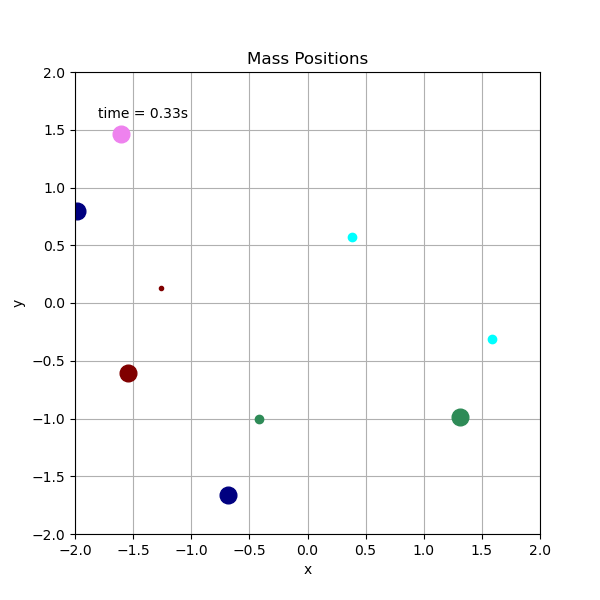

In [77]:
%matplotlib notebook

num_points = len(vel_final_mm)
multi_mass = True

# print((num_points))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_2d_mm[0],box_2d_mm[1]), ylim=(box_2d_mm[2], box_2d_mm[3]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']
if multi_mass == True:
    markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d_mm[_])*3][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]
else:
    markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d_mm[_])*10][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]

    # markers = [ax.plot([], [], 'o-', markersize=10)[0] for _ in range(num_points)]

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    for j, marker in enumerate(markers):
        marker.set_data([part_2d_mm[j,0, i]], [part_2d_mm[j,1,i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times)), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()


## Energy Calculation
Due to the large amount of errors produced in the 1D case for a multi-mass system, I wanted to see if these results would be replicated in the 2D version. Additionly, the box size has been reduced greatly which should lead to potentail energys staying higher in this system. 

In [78]:
U = [0,0]
T = [0,0]

for i in range(len(vel_int2d_mm)):
    for j in range(i+1,len(vel_int2d_mm)):
        if i == j:
            continue 
        U[0] += bestpot2d(part_2d_mm[i,:,0],part_2d_mm[j,:,0],box_2d_mm)
        U[1] += bestpot2d(part_2d_mm[i,:,-1],part_2d_mm[j,:,-1],box_2d_mm)
    T[0] += 1/2*mass_2d_mm[i]*np.sqrt(vel_int2d_mm[i,0]**2+vel_int2d_mm[i,1]**2)**2
    T[1] += 1/2*mass_2d_mm[i]*np.sqrt(vel_final_mm[i,0]**2+vel_final_mm[i,1]**2)**2


# print(U)
# print(T)
print(f"Intial Potential = {round(U[0],4)} ; Final Potential = {round(U[1],4)}")
print(f"Intial KE = {round(T[0],4)} ; Final KE = {round(T[1],4)}")
print(f"Intial Energy = {round(energycalc(U[0],T[0]),4)} \nFinal Energy  = {round(energycalc(U[1],T[1]),4)}")
print(f"Energy Change =", round(energycalc(U[1],T[1]) - energycalc(U[0],T[0]),4) )

Intial Potential = 3057.0939 ; Final Potential = 166.8922
Intial KE = 13.5 ; Final KE = 2908.8285
Intial Energy = 3070.5939 
Final Energy  = 3075.7207
Energy Change = 5.1268


Looking at the results of the calculation, we can see that with a reduced box size the particles do keep a higher potential energy throughout the simulation. The final energy has a similar deficiency as seen in the non-uniform mass simulation for 1D but with a larger scale. I suspect that due to the increased number of collisions with this box size, the errors get compounded at a much higher rate. I ran this calculation with a step size of .001 seconds to limit computation time but have noticed some simulations have much worse energy conservation than others. There are two ways you could address this issue, first, you could ignore trials with worse energy conservation and opt to rerun the program, you could also reduce step size, increasing computation time to get more accurate results.

## Steady State
Looking at the force vs distance graph at the beginning of the report, it looks like there could be a separation distance at which the particles all pull and push equally creating a pulsing motion. The conditions to achieve this require a small box and initial spacings at the minimum of the force plot. I first tested different spacings of the box around the minimum point of the force vs time plot (x=1.2444551). The system with this condition would pulse until the simulation reached 2 seconds at which point the edges would begin to break off and the system would pulse in a diamond shape afterwards. I would see similar results increasing the distances. I then tried to reduce the distances and saw more stability. 

Through trial and error, I found the best spacing to be 1.2444551-.055. With this spacing, a 3x3 system showed stability with .1 second step sizes up to at least 500 seconds. 

I then experimented with a 5x5 system that also worked for a .1 second time step size to at least 30 seconds. I assumed that the systems would be more stable for even (ie. 4x4) sets of particles but these seem to break entirely for these simulations even with smaller time steps.

In [79]:
fast = 0
multi_mass = 0
rand_vel = 0

steady = 1.2444551 -.07     # spacings for steady state 
debugstart = 0  # [in ms]
debugend = 0  # [in ms]
x = np.arange(-steady*1,steady*1+.1,steady)  # init pos
y = np.arange(-steady*1,steady*1+.1,steady)
h = 1e-2 # time step
endtime = 10  # [seconds]
acceptable_masses = [1,2,4]
box = [(x[0]-steady/13*7), (x[-1]+steady/13*7),(y[0]-steady/13*7),(y[-1]+steady/13*7)]  # edge locations

# set up
particles = np.zeros([len(x)*len(y),2])
count = 0
for i in range(len(x)):
    for j in range(len(y)):
        particles[count] = x[i],y[j]
        count +=1
# print(len(particles))
vy = np.zeros(len(particles))
vx = np.zeros(len(particles))  # init velos
f = np.zeros([len(x)*len(y),2])  # init forces
mass = np.ones((len(particles)))                       #deal with later




# CODE
time = 0



if multi_mass ==True:
    mass_selction(acceptable_masses)
times = np.arange(0, endtime, h)
pos_list = np.zeros((len(x)*len(y),2,len(times)))
pos_list[:,:,0] = particles
tot_f = np.zeros((len(x)*len(y),2))
flist = np.zeros((len(x)*len(y),2, len(times)))
vel_list = []
for i in range(len(particles)):  # turn back on
    rand_num = (random.uniform(0, 2 * np.pi))
    if rand_vel == True:
        vx[i] = np.cos(rand_num)
        vy[i] = np.sin(rand_num)
    else:
        vx[i] = 0
        vy[i] = 0
    vel_list.append([vx[i],vy[i]])
vel_list=np.array(vel_list)
vel_int = np.copy(vel_list)
velx_int = np.copy(vx)
vely_int = np.copy(vy)


compute1()

particles
flist[:,:,0] = tot_f

compute2()

part_2d_ss1 = np.copy(pos_list)
vel_int2d_ss1 = np.copy(vel_int)
vel_final_ss1 = np.copy(vel_list)
flist_2d_ss1 = np.copy(flist)
mass_2d_ss1 = np.copy(mass)
box_2d_ss1 = np.copy(box)

## Animation

<IPython.core.display.Javascript object>


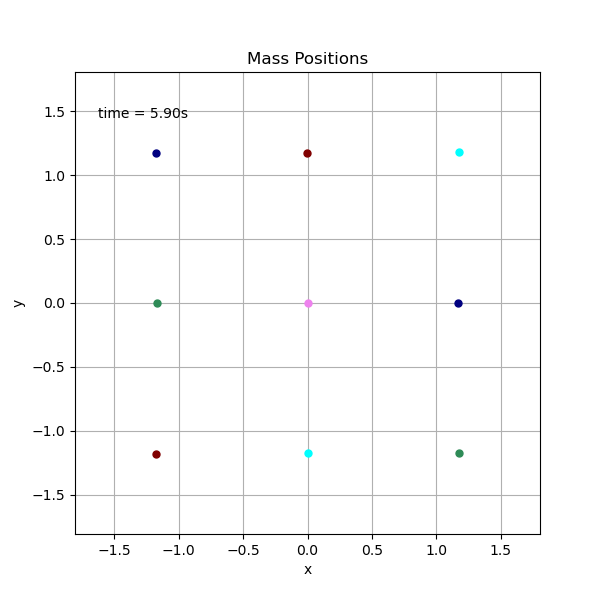

In [80]:
%matplotlib notebook

multi_mass = False
num_points = len(vel_int2d_ss1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_2d_ss1[0],box_2d_ss1[1]), ylim=(box_2d_ss1[2], box_2d_ss1[3]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']
markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d_ss1[_])*5][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]
# markers = [ax.plot([], [], 'o-', markersize=10)[0] for _ in range(num_points)]

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    for j, marker in enumerate(markers):
        marker.set_data([part_2d_ss1[j,0, i]], [part_2d_ss1[j,1,i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times),1), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()


# Energy Calculation
Since this state remains near the initial positions, the energy for this state should remain mostly potential. To check this is the case I have provided the calculations below.

In [81]:
U = [0,0]
T = [0,0]
for i in range(len(vel_int2d_ss1)):
    for j in range(i+1,len(vel_int2d_ss1)):
        if i == j:
            continue 
        U[0] += bestpot2d(part_2d_ss1[i,:,0],part_2d_ss1[j,:,0],box_2d_ss1)
        U[1] += bestpot2d(part_2d_ss1[i,:,-1],part_2d_ss1[j,:,-1],box_2d_ss1)
    T[0] += 1/2*mass_2d_ss1[i]*np.sqrt(vel_int2d_ss1[i,0]**2+vel_int2d_ss1[i,1]**2)**2
    T[1] += 1/2*mass_2d_ss1[i]*np.sqrt(vel_final_ss1[i,0]**2+vel_final_ss1[i,1]**2)**2


# print(U)
# print(T)
print(f"Intial Potential = {abs(round(U[0],4))} ; Final Potential = {abs(round(U[1],4))}")
print(f"Intial KE = {round(T[0],4)} ; Final KE = {round(T[1],4)}")
print(f"Intial Energy = {round(abs(energycalc(U[0],T[0])),4)} \nFinal Energy  = {round(abs(energycalc(U[1],T[1])),4)}")
print(f"Energy Change =", round(abs(energycalc(U[1],T[1])) - abs(energycalc(U[0],T[0])),4) )

Intial Potential = 13.0177 ; Final Potential = 12.8025
Intial KE = 0.0 ; Final KE = 0.0281
Intial Energy = 13.0177 
Final Energy  = 12.7744
Energy Change = -0.2433


As expected, the energy in the system remains mostly potential with only a small amount being turned into kinetic energy. There is a loss of energy in this system but this is likely due to the very large step sizes used to find this state. Using a step size of only .01 seconds still conserves energy better than any other calculation in 1D or 2D for this step size. 

## 5 x 5 Stable State
This is just a proof of concept for larger systems of particles

In [82]:
# CONTROLS
fast = 0
multi_mass = 0
rand_vel = 0
steady = 1.2444551-.055
debugstart = 0  # [in ms]
debugend = 0  # [in ms]
x = np.arange(-steady*2,steady*2+.1,steady)  # init pos
y = np.arange(-steady*2,steady*2+.1,steady)
h = 1e-2 # time step
endtime = 10  # [seconds]
acceptable_masses = [1,2,4]
box = [(x[0]-steady/13*7), (x[-1]+steady/13*7),(y[0]-steady/13*7),(y[-1]+steady/13*7)]  # edge locations




particles = np.zeros([len(x)*len(y),2])
count = 0
for i in range(len(x)):
    for j in range(len(y)):
        particles[count] = x[i],y[j]
        count +=1
# print(len(particles))
vy = np.zeros(len(particles))
vx = np.zeros(len(particles))  # init velos
f = np.zeros([len(x)*len(y),2])  # init forces
mass = np.ones((len(particles)))                       #deal with later


if multi_mass ==True:
    mass_selction(acceptable_masses)
times = np.arange(0, endtime, h)
pos_list = np.zeros((len(x)*len(y),2,len(times)))
pos_list[:,:,0] = particles
tot_f = np.zeros((len(x)*len(y),2))
flist = np.zeros((len(x)*len(y),2, len(times)))
vel_list = []
for i in range(len(particles)):  # turn back on
    rand_num = (random.uniform(0, 2 * np.pi))
    if rand_vel == True:
        vx[i] = np.cos(rand_num)
        vy[i] = np.sin(rand_num)
    else:
        vx[i] = 0
        vy[i] = 0
    vel_list.append([vx[i],vy[i]])
vel_list=np.array(vel_list)
vel_int = np.copy(vel_list)
velx_int = np.copy(vx)
vely_int = np.copy(vy)



compute1()
# exit()


compute2()

part_2d_ss2 = np.copy(pos_list)
vel_int2d_ss2 = np.copy(vel_int)
vel_final_ss2 = np.copy(vel_list)
flist_2d_ss2 = np.copy(flist)
mass_2d_ss2 = np.copy(mass)
box_2d_ss2 = np.copy(box)

## 5 x 5 Stable State Animation

<IPython.core.display.Javascript object>


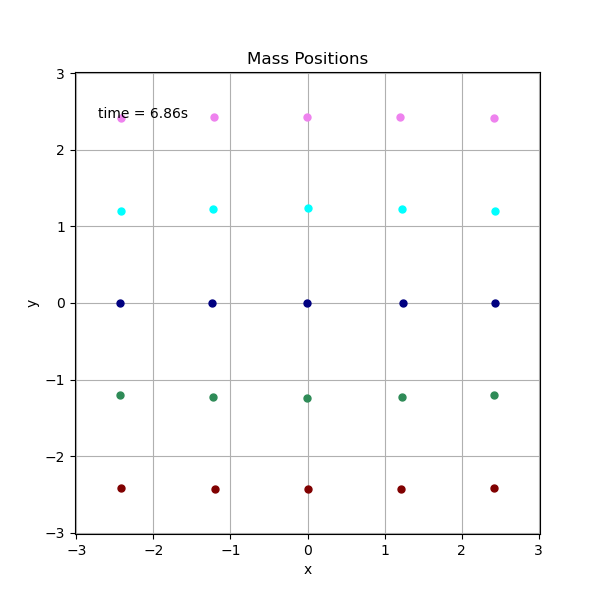

In [83]:
%matplotlib notebook

multi_mass = False
num_points = len(vel_final_ss2)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(box_2d_ss2[0],box_2d_ss2[1]), ylim=(box_2d_ss2[2], box_2d_ss2[3]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

#Creating markers for each point dynamically
color_palette = ['maroon', 'seagreen', 'navy', 'cyan', 'violet']
markers = [ax.plot([], [], 'o-', markersize=[int(mass_2d_ss2[_])*5][0], color=color_palette[ _ % len(color_palette)])[0] for _ in range(num_points)]
# markers = [ax.plot([], [], 'o-', markersize=10)[0] for _ in range(num_points)]

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    for marker in markers:
        marker.set_data([], [])
    time_text.set_text('')
    return markers + [time_text]

def animate(i):
    for j, marker in enumerate(markers):
        marker.set_data([part_2d_ss2[j,0, i]], [pos_list[j,1,i]])
    time_text.set_text(time_template % (i * h))
    return markers + [time_text]

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(times),1), interval=1, blit=True, init_func=init)

#We will display the animation as a static image for demonstration
plt.show()


# Conclusion

## What Needs Further Analysis

The first thing that should be addressed in furthering these simulations is optimizing the calculations. Constructing the clone particles is necessary but finding a simple way to only construct the necessary ones would go a long way in improving computation time. A further analysis of the energy lost in the system for non-uniform mass simulations would also be an important investigation. It is clear that in these simulations the particles underestimate the velocity of the system but the reason why is still a mystery. Lastly, extending this simulation to higher dimensions to analyze the 3D case would be fruitful.

I would like to take these simulations to 3D but I have already crashed the class server with the computations above so I will simply outline the procedure for taking this calculation up to higher dimensions.
first: Add mirrors for the newly constructed cube, there should be 27 particles for each one located in the box.
Second: Calculate the forces using the magnitude of the forces and angles of the particles.
Third: Change the index on the loops for x and y to include z, two's go to three
Fourth: Change animation code to work in 3D
Thats all that should be needed for this increase in dimensions

## What Was Shown

This project demonstrates the implementation of a Verlet Velocity simulation in both 1D and 2D. While building this project, I learned the importance of creating clone particles as without them, particles traveling through walls may get closer than reasonably possible leading to incredibly high velocities. The second important takeaway from this project is balancing accuracy with computation time. The best simulation would require time steps that approach 0. The issue with this is computation time, calculating the force between each particle takes a long time in addition to updating velocity and positions throughout time. For this reason, I took time steps of .001 seconds for periods of 5 seconds for a total of 5000 calculations. Testing the energy conservation of each system we see that, apart from minor fluctuations, energy is conserved. With smaller step sizes the energy test gets exponentially better. For simulations where the particles are the same size, the energy rises in the system due to particles traveling farther into force barriers than would normally be possible with time steps of 0. This leads to a small amount of energy entering the system throughout time. Systems of particles with non-uniform mass tend to lose energy. This is likely due to an underestimation of velocities for the larger particles. The system was also tested in reverse to ensure that the calculations were being performed correctly. It was shown in both 1D and 2D that calculations can be run both forwards and backward to get the same results. 

To show the physical results of this system, it was shown that temperature and pressure could be calculated in the system for non-ideal gasses. This showed the unique result of pressure in a system still fluctuating after the temperature in the system reached equilibrium due to particle interactions. For the 2D case, it was shown that these systems also have states at which the particles remain in their original state if given correct spacings.

## References

[1] Rubin Landau, Manuel Paez, and Christian Bordeanu. 2015. Computational Physics: Problem
Solving with Python. Third Edition, Wiley-VCH.

[2] Ulf Schiller. March 5th, 2008. An Overview of Integration Schemes for Molecular Dynamics
Simulations. Clemson University, Lecture Notes.

[3] Niels Grønbech-Jensen and Oded Farago. Jan 29, 2013. A Simple and Effective Verlet-type
Algorithm for Simulating Langevin Dynamics. Molecular Physics Vol.111:983-993.

[4] Badar, M.S., Shamsi, S., Ahmed, J., Alam, M.A. (2022). Molecular Dynamics Simulations:
Concept, Methods, and Applications. In: Rezaei, N. (eds) Transdisciplinarity. Integrated Science,
vol 5. Springer, Cham.

[5] Takahiro Sakagami and Kazuhiro Fuchizaki. 2010. Phase diagram of a modified
Lennard-Jones system. J. Phys.: Conf. Ser. 215 012123

[6] Allen, Michael P., and Dominic J. Tildesley. 23 Nov. 2017. Computer Simulation of Liquids.
2nd edn Oxford, 2017; online edn, Oxford Academic. Chapter 4, Molecular Dynamics
Simulations; p. 21-41.
